# Sample Pipeline

This notebook shows an end to end radio interferometry pipeline from the simulation of the sky to the final image. In addition, it produces a catalogue of the sources in the image pixel domain. This is just an example notebook and thus the functions are not well structured and capsulated yet.

The pipeline consists of three modules:

- Simulation
    - Sky module: OSKAR
    - Telescope module incl. calibration: OSKAR
- Processing
    - Calibration after observation: RASCIL
    - Deconvolution: RASCIL
- Analysis & comparison
    - Quantitative and qualitative analysis of algorithms

In [1]:
import sys
import oskar
import matplotlib
import matplotlib.pyplot as plt
from astropy.visualization import astropy_mpl_style
import numpy as np

from astropy.utils.data import get_pkg_data_filename
from astropy.io import fits
from astropy import wcs

In [2]:
plt.style.use(astropy_mpl_style)

## Simulation

The sky and telescope simulation is currently provided completely by OSKAR.

### Sky Module

The sky module of OSKAR contains radiation sources, which are defined as array and can be passed to `oskar.Sky.from_array`.

In [ ]:
# Set the numerical precision to use.
precision = "single"

# Create a sky model containing three sources from a numpy array.
sky_data = np.array([
        [20.0, -30.0, -1, 0, 0, 0, 100.0e6, -0.7, 0.0, 0,   0,   0],
        [20.0, -30.5, 3, 2, 2, 0, 100.0e6, -0.7, 0.0, 600, 50,  45],
        [20.5, -30.5, 3, 0, 0, 2, 100.0e6, -0.7, 0.0, 700, 10, -10]])
sky = oskar.Sky.from_array(sky_data, precision)  # Pass precision here.

Instead of using completely artificial sources, an external catalog can also be used. Here we use the GLEAM survey, which can be downloaded from the [VizieR](https://cdsarc.unistra.fr/viz-bin/cat/VIII/100) service. 

This example is using the [GLEAM EGC catalog, version 2](https://vizier.cds.unistra.fr/viz-bin/VizieR-3). To download the full survey, you have to change **preferences/max** to unlimited. The download here was done using the **FITS (binary) Table** option which can be selected in the dropdown below.

For this example we only use right ascension (RAJ2000) and declination (DEJ2000) and the Stokes I peak flux intensity at 76 MHz (Fp076). There are some sources which have no flux values in the corresponding frequency band. These must be removed first.

In [17]:
from astropy.table import Table

gleam = Table.read('./GLEAM_EGC.fits')
df_gleam = gleam.to_pandas()
df_gleam.head()

,GLEAM,RAJ2000,DEJ2000,Fpwide,Fintwide,awide,bwide,pawide,Fp076,Fint076,...,a220,b220,pa220,Fp227,Fint227,a227,b227,pa227,alpha,Fintfit200
0,b'J235139-894114',357.914368,-89.687309,0.262282,0.248581,219.263,146.4811,-4.158033,0.531743,0.528997,...,171.534,127.1215,-4.158033,0.097147,0.090779,170.630,123.0671,-4.158033,-0.370882,0.271901
1,b'J223320-891247',338.336243,-89.213310,0.160685,0.150291,217.707,145.0885,8.403455,-0.032964,-0.032702,...,169.540,125.5117,8.403455,0.084467,0.076873,168.625,121.4038,8.403455,NaN,NaN
2,b'J231335-890921',348.399048,-89.155968,0.311750,0.320281,234.137,148.1622,-1.929386,0.459728,0.463359,...,190.178,129.0525,-1.929386,0.219189,0.230755,189.363,125.0609,-1.929386,-0.751062,0.321428
3,b'J230111-884502',345.296844,-88.750610,1.540468,1.589200,203.822,170.7923,-2.558145,2.683800,2.686571,...,154.506,151.2983,87.441856,1.146250,1.157487,151.188,150.2724,87.441856,-0.453153,1.496247
4,b'J211508-884427',318.784729,-88.740990,0.137430,0.192555,282.809,167.1542,26.895504,0.368415,0.393777,...,247.645,150.4759,26.895504,0.015579,0.025159,247.020,147.0669,26.895504,-0.239030,0.199019


In [25]:
start_frequency_hz = 76e6
df_gleam = df_gleam[~df_gleam['Fp076'].isna()]
ra, dec, fp = df_gleam['RAJ2000'], df_gleam['DEJ2000'], df_gleam['Fp076'
sky_array = np.column_stack((ra, dec, fp, np.zeros(ra.shape[0]), np.zeros(ra.shape[0]), 
                             np.zeros(ra.shape[0]), [start_frequency_hz]*ra.shape[0])).astype('float32')
precision = "single"
sky = oskar.Sky.from_array(sky_array, precision) # 307455 sources
sky.num_sources

307087

Before further steps are taken, the phase center of the telescope must be defined.

In [26]:
ra0 = 250
dec0 = -80
phase_center = [ra0,dec0]

/tmp/ipykernel_468/2105936447.py:7: RuntimeWarning: invalid value encountered in log10
  log_flux = np.log10(flux) # doesn't work as intended yet because of log of negative values
/tmp/ipykernel_468/2105936447.py:16: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(sc, label='Log10(Stokes I flux [Jy])')


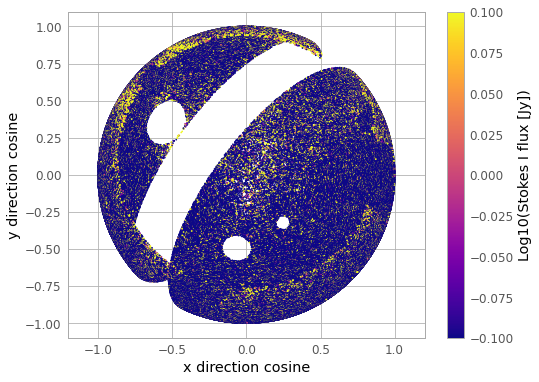

In [27]:
def plot_sky(sky, phase_center):
    ra0, dec0 = phase_center[0], phase_center[1]
    data = sky.to_array()
    ra = np.radians(data[:, 0] - ra0)
    dec = np.radians(data[:, 1])
    flux = data[:, 2]
    log_flux = np.log10(flux) # doesn't work as intended yet because of log of negative values
    x = np.cos(dec) * np.sin(ra)
    y = np.cos(np.radians(dec0)) * np.sin(dec) - \
                np.sin(np.radians(dec0)) * np.cos(dec) * np.cos(ra)
    sc = plt.scatter(x, y, s=.5, c=log_flux, cmap='plasma',
                vmin=np.min(log_flux), vmax=np.max(log_flux))
    plt.axis('equal')
    plt.xlabel('x direction cosine')
    plt.ylabel('y direction cosine')
    plt.colorbar(sc, label='Log10(Stokes I flux [Jy])')
    plt.show()
    
plot_sky(sky, phase_center)

Now that we have determined the phase center we can take a closer look at how the point sources are distributed around the center. For this we use a coordinate 2d image projection with the phase center as the origin using the the world coordinate system ([wcs](https://docs.astropy.org/en/stable/wcs/index.html)) of astropy. Specific information about the wcs parameters can be found [here](https://docs.astropy.org/en/stable/api/astropy.wcs.Wcsprm.html). For this illustration, we do not take into account the flux intensity, so that all sources are clearly visible.

/tmp/ipykernel_468/3129262687.py:14: RuntimeWarning: invalid value encountered in log10
  log_flux = np.log10(fp.to_numpy())
/tmp/ipykernel_468/3129262687.py:19: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(sc, label='Log10(Stokes I flux [Jy])')


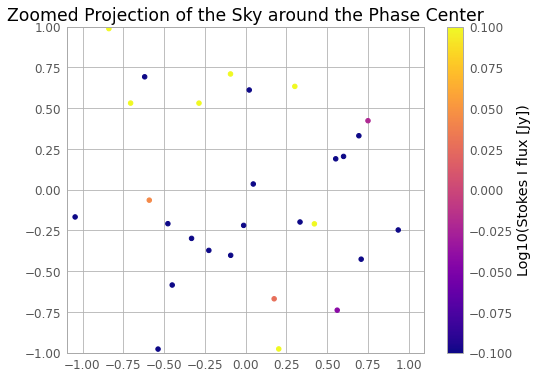

In [28]:
#### Construct Fits file ######
w = wcs.WCS(naxis=2)
# define coordinate reference pixel per axis
w.wcs.crpix = [0, 0]
# coordinate increments on sphere per axis
w.wcs.cdelt = np.array([-1, 1])
# coordinate reference values per axis (ra/deg)
w.wcs.crval = phase_center
# coordinate axis type
w.wcs.ctype = ["RA---AIR", "DEC--AIR"]
# coordinate transformation
px, py = w.wcs_world2pix(ra, dec, 1)
# flux
log_flux = np.log10(fp.to_numpy())

sc = plt.scatter(px, py, s=20, c=log_flux, cmap='plasma',
                 vmin=np.min(log_flux), vmax=np.max(log_flux))
plt.axis('equal')
plt.colorbar(sc, label='Log10(Stokes I flux [Jy])')
plt.title('Zoomed Projection of the Sky around the Phase Center')
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.show()

Now, to have only a partition of the sky, we can use the `filter_by_radius`, which filters from the phase center with an inner and outer radius in degrees. Oskar also provides the function `filter_by_flux` to filter by Stokes-I flux. For more details we refer to the Oskar [documentation](https://fdulwich.github.io/oskarpy-doc/sky.html).

In [29]:
def intersect2D(a, b):
    """
    Find row intersection indices of the whole set between 2D numpy arrays, a and b.
    This assumes that the bigger one of a or b is the whole set and the other is a subset of it.
    Returns the set-indices as np.ndarray
    """
    a, b = a.copy(), b.copy()
    # swap "a" and "b" if necessary so that "b" is always supposed to be a subset of "a"
    if b.shape[0] > a.shape[0]:
        tmp = a
        a = b
        b = tmp
    
    nrows, ncols = a.shape
    dtype={'names':['f{}'.format(i) for i in range(ncols)],
           'formats':ncols * [a.dtype]}
    c = np.intersect1d(a.view(dtype), b.view(dtype), return_indices=True)
    
    a_idxs = c[1] # 0=values, 1=a_idxs, 2=b_idxs
    
    return a_idxs



# first filter sky by inner and outer radius in degrees from the phase center
sky.filter_by_radius(0, .55, phase_center[0], phase_center[1])
data = sky.to_array()

# now get the indices of the dataframe survey (.iloc indices, not df_survey.index indices)
# needs to be decimals 4 because oskar.Sky.from_array doesn't match anymore exactly after reading. this is not tested yet if it works always as intended
ra_dec_all = np.round(df_gleam[['RAJ2000','DEJ2000']].to_numpy(dtype='float32'), decimals=4)
ra_dec_filtered = np.round(data[:,0:2], decimals=4)
gleam_filtered_idxs = intersect2D(ra_dec_all, ra_dec_filtered)
df_gleam_filtered = df_gleam.iloc[gleam_filtered_idxs]

# create new Sky, otherwise a matching between the filtered survey dataframe and the original filtered Sky would be necessary
ra_filtered, dec_filtered, fp_filtered = df_gleam_filtered['RAJ2000'], df_gleam_filtered['DEJ2000'], df_gleam_filtered['Fp076']
sky_array = np.column_stack((ra_filtered, dec_filtered, fp_filtered, np.zeros(ra_filtered.shape[0]), np.zeros(ra_filtered.shape[0]), 
                             np.zeros(ra_filtered.shape[0]), [start_frequency_hz]*ra_filtered.shape[0]))
precision = "single"
sky = oskar.Sky.from_array(sky_array, precision)

data = sky.to_array()
ra_filtered = data[:,0]
dec_filtered = data[:,1]
stokes_i_flux = data[:,2]
source_name = df_gleam_filtered['GLEAM']
sky.num_sources

8

Now let's look at the filtered sources.

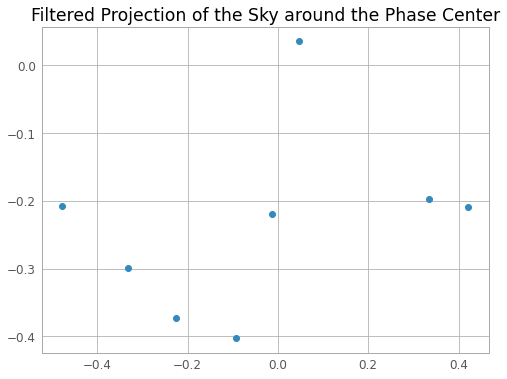

In [30]:
px, py = w.wcs_world2pix(ra_filtered, dec_filtered, 1)

fig, ax = plt.subplots()
ax.scatter(px, py)

for i, txt in enumerate(source_name):
    #ax.annotate(txt, (px[i], py[i]))
    pass
    
plt.title('Filtered Projection of the Sky around the Phase Center')
plt.show()

### Telescope Module

Various observation parameters and meta information `params` must be passed to the telescope module `oskar.Interferometer` of OSKAR as `oskar.SettingsTree`.

In [31]:
# Basic settings. (Note that the sky model is set up later.)
params = {
    "simulator": {
        "use_gpus": False
    },
    "observation" : {
        #"num_channels": 64,
        "num_channels": 16,
        "start_frequency_hz": start_frequency_hz,
        "frequency_inc_hz": 20e6,
        "phase_centre_ra_deg": phase_center[0],
        "phase_centre_dec_deg": phase_center[1],
        "num_time_steps": 24,
        "start_time_utc": "01-01-2000 12:00:00.000",
        "length": "12:00:00.000"
    },
    "telescope": {
        "input_directory": "../data/telescope.tm"
    },
    "interferometer": {
        "ms_filename": "visibilities_gleam.ms",
        "channel_bandwidth_hz": 1e6,
        "time_average_sec": 10
    }
}
settings = oskar.SettingsTree("oskar_sim_interferometer")
settings.from_dict(params)

precision = "single"
if precision == "single":
    settings["simulator/double_precision"] = False

# Set the sky model and run the simulation.
sim = oskar.Interferometer(settings=settings)

### Observation Simulation

Now the sky module must be passed to the interferometer and the simulation of the observation must be started to generate the measurement set.

In [32]:
sim.set_sky_model(sky)
sim.run()

## Processing

After the observation is made with the telescope, a calibration of the measured data must be performed, followed by the reconstruction of the image.

### Calibration after Observation

toDo

In [ ]:
# Code here

### Imaging

Start an mmclean algorithm with the visibilites.ms as an input to deconvolve. 
To use dask cluster where you can see the progress, first create a dask cluster in the dask-extension on the left. 
Then copy the scheduler adress into the variable below. It might be correct already.

If you don't do this, remove the --dask_scheduler option from the options in the start_imager call.
Then RASCIL starts its own scheduler, you will however not be able to see the dashbaord, as the port is probably not forwarded by docker.

In [ ]:
from rascil.apps import rascil_imager
from rascil.processing_components.util.performance import (
    performance_store_dict,
    performance_environment,
)
    
def start_imager(rawargs):
    parser = rascil_imager.cli_parser()
    args = parser.parse_args(rawargs)
    performance_environment(args.performance_file, mode="w")
    performance_store_dict(args.performance_file, "cli_args", vars(args), mode="a")
    image_name = rascil_imager.imager(args)

start_imager(
    [
        '--ingest_msname','visibilities_gleam.ms',
        '--ingest_dd', '0', 
        #'--ingest_vis_nchan', '64',
        '--ingest_vis_nchan', '16',
        #'--ingest_chan_per_blockvis', '4',
        '--ingest_chan_per_blockvis', '1' ,
        '--ingest_average_blockvis', 'True',
        '--imaging_npixel', '2048', 
        '--imaging_cellsize', '3.878509448876288e-05',
        '--imaging_weighting', 'robust',
        '--imaging_robustness', '-0.5',
        '--clean_nmajor', '2' ,
        '--clean_algorithm', 'mmclean',
        '--clean_scales', '0', '6', '10', '30', '60',
        '--clean_fractional_threshold', '0.3',
        '--clean_threshold', '0.12e-3',
        '--clean_nmoment' ,'5',
        '--clean_psf_support', '640',
        '--clean_restored_output', 'integrated'
    ])

## Analysis and Comparison

toDo

Now we have the image of the pipeline and the corresponding pixel coordinates as ground truth. Important are the number of set pixels and the cellsize, from which the coordinates are calculated.

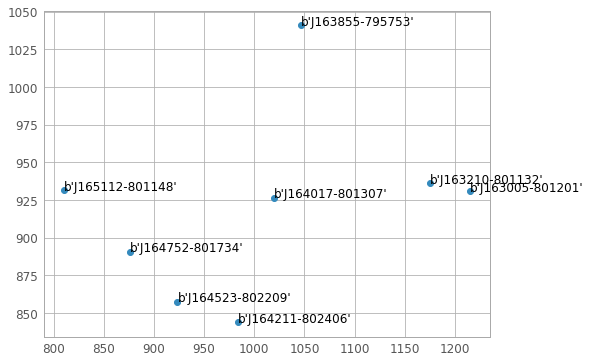

In [33]:
hdulist = fits.open('./visibilities_gleam_nmoment5_cip_deconvolved.fits')
w_fits = wcs.WCS(hdulist[0].header)

#### Construct Fits file ######
w = wcs.WCS(naxis=2)
w.wcs.crpix = w_fits.wcs.crpix[0:2] # coordinate reference pixel per axis --> on image
w.wcs.cdelt = w_fits.wcs.cdelt[0:2] # coordinate increments on sphere per axis
w.wcs.crval = [phase_center[0], phase_center[1]]
w.wcs.ctype = ["RA---AIR", "DEC--AIR"] # coordinate axis type
px, py = w.wcs_world2pix(ra_filtered, dec_filtered, 1) # coordinate conversion
fig, ax = plt.subplots()
ax.scatter(px, py)

for i, txt in enumerate(source_name):
    ax.annotate(txt, (px[i], py[i]))
    pass
plt.show()

In [43]:
import pandas as pd
px_coord = pd.DataFrame({'source':source_name, 'px':px, 'py':py, 'stokes_I_flux':df_gleam_filtered['Fp076']})
px_coord

,source,px,py,stokes_I_flux
256932,b'J163005-801201',1214.682496,930.813835,1.303971
256945,b'J163210-801132',1175.053128,935.950129,0.132092
257012,b'J163855-795753',1046.058327,1040.785445,0.446424
256935,b'J164017-801307',1019.481126,926.596811,0.591116
256915,b'J164211-802406',983.753022,843.993927,0.703838
256924,b'J164523-802209',923.477401,857.575425,0.631879
256929,b'J164752-801734',875.761466,890.715306,0.592038
257005,b'J165112-801148',810.424743,931.271274,0.509679
